## Modeling for predicting hospitalization at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/ISSS623_2024-main/Group_Project/Self_Learning-MIMIC/')
path = '/content/drive/My Drive/ISSS623_2024-main/Group_Project/Self_Learning-MIMIC/'

In [ ]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers_for_tasks import PlotROCCurve

In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/ISSS623_2024-main/Group_Project/Self_Learning-MIMIC/train2.csv')
df_test = pd.read_csv('/content/drive/My Drive/ISSS623_2024-main/Group_Project/Self_Learning-MIMIC/test2.csv')
confidence_interval = 95
random_seed=0

In [ ]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### 1. task-specific filter: exclude ED death cases for train and test

In [ ]:
df_train = df_train[df_train['ed_death'] == False].reset_index()
df_test = df_test[df_test['ed_death'] == False].reset_index()

### 2. Variable Selection

In [ ]:
variable = ["age", "gender",

            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d",
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d",

            "triage_temperature", "triage_heartrate", "triage_resprate",
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",

            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough",
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",

            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia",
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1",
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2",
            "cci_Cancer2", "cci_HIV",

            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy",
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_hospitalization"

In [ ]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [ ]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,float64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [ ]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [ ]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.8995975931003647 : 1


### 3.  Modeling script

In [ ]:
# List for all results
result_list = []

Logistic Regression:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 6.884692907333374 seconds
AUC: 0.8074228684444663
AUPRC: 0.774419106031196
Sensitivity: 0.7323267481216544
Specificity: 0.7336659641274894
Score thresold: 0.46395251063730514
2.5 97.5


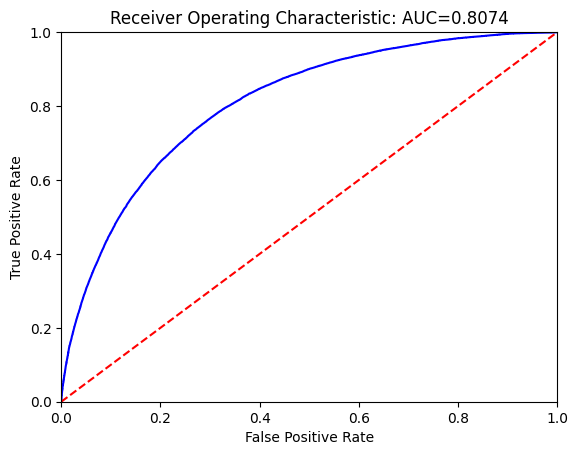

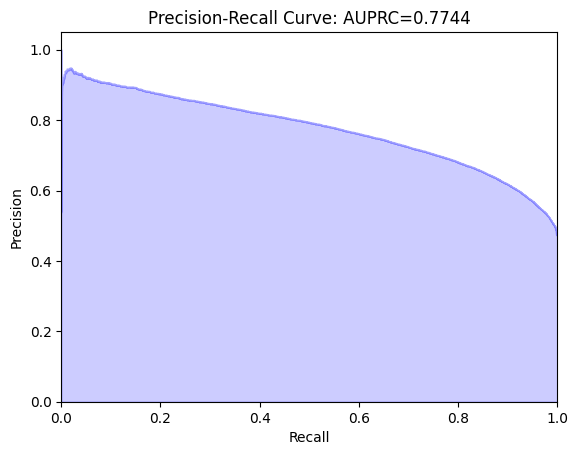

In [ ]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



RandomForest:
Training time: 87.83831930160522 seconds
AUC: 0.8187971319829649
AUPRC: 0.7890933854033249
Sensitivity: 0.7473295086295878
Specificity: 0.736483289603854
Score thresold: 0.49333333333333335
2.5 97.5


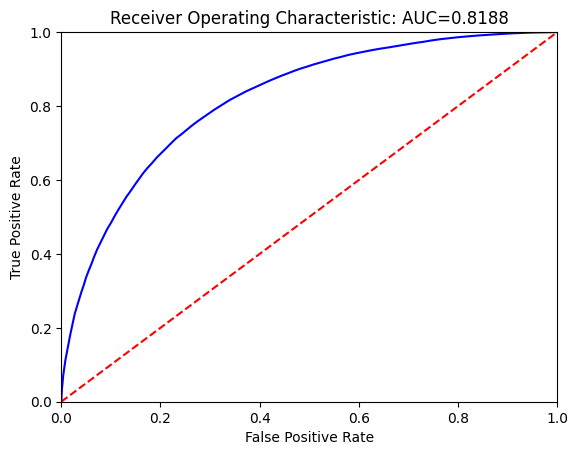

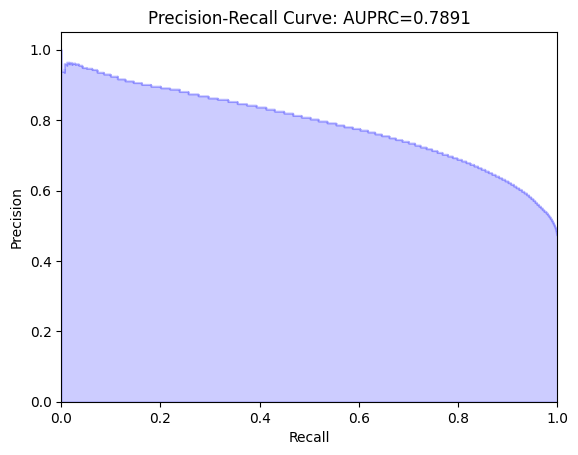

[1.26140266e-01 1.31946876e-02 7.69192584e-03 1.14437183e-02
 2.24443636e-02 6.75811444e-03 1.67533879e-02 2.70969796e-02
 1.22000359e-04 7.02059023e-04 2.49817668e-03 7.87553542e-02
 8.57862690e-02 3.97620176e-02 4.38336110e-02 8.72273047e-02
 8.29800729e-02 4.82924258e-02 1.10253157e-01 6.90177162e-03
 8.94469364e-03 4.98922219e-03 5.45250167e-04 4.28146596e-03
 2.81394401e-03 3.88585050e-03 4.34933342e-03 3.54286690e-03
 4.24270996e-03 3.07286820e-03 5.29670124e-03 2.95436026e-03
 3.09425448e-03 1.39480616e-03 6.31203240e-03 2.18572163e-03
 1.54586992e-03 3.83696177e-03 6.41911229e-03 3.76942887e-03
 1.27569939e-03 5.85287801e-03 4.45823608e-03 1.46177811e-03
 1.97268522e-03 1.06876138e-03 6.86544029e-03 2.86695117e-03
 2.60425837e-03 6.34459125e-03 1.03046901e-02 4.57618773e-03
 4.33037684e-03 9.82604946e-04 4.34940430e-03 4.79021647e-03
 3.48458082e-03 1.18736006e-02 1.17091512e-03 3.42805029e-03
 5.04678131e-03 4.34477204e-03 2.84963856e-03 7.58178454e-03]


In [ ]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 83.53966784477234 seconds
AUC: 0.8186852978220994
AUPRC: 0.7958444377559575
Sensitivity: 0.7472094865455243
Specificity: 0.7320099789238247
Score thresold: 0.48262434212362276
2.5 97.5


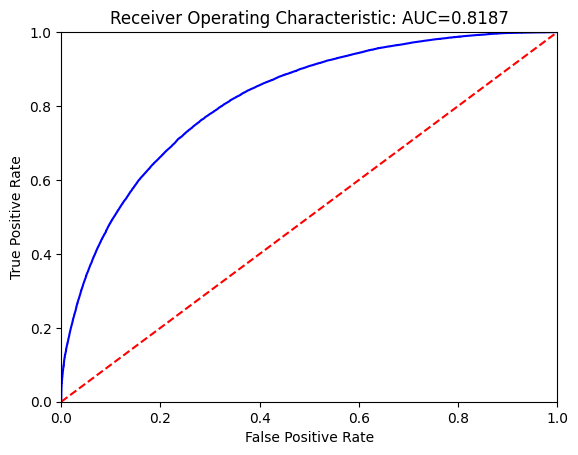

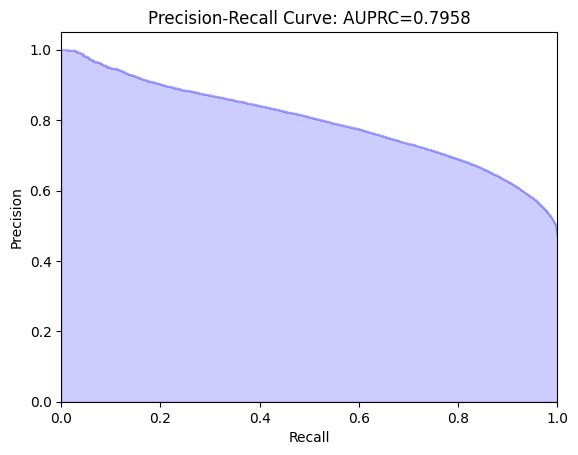

In [ ]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [ ]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [ ]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')},
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('hospitalization_triage_mlp')

Epoch 1/20
1764/1764 [==============================] - 16s 5ms/step - loss: 0.6252 - accuracy: 0.7102 - auc: 0.7756 - auprc: 0.7351 - true_positives: 111662.0000 - true_negatives: 138785.0000 - precision: 0.7044 - recall: 0.6687
Epoch 2/20
1764/1764 [==============================] - 9s 5ms/step - loss: 0.5385 - accuracy: 0.7272 - auc: 0.8032 - auprc: 0.7792 - true_positives: 115850.0000 - true_negatives: 140587.0000 - precision: 0.7200 - recall: 0.6937
Epoch 3/20
1764/1764 [==============================] - 10s 6ms/step - loss: 0.5315 - accuracy: 0.7313 - auc: 0.8086 - auprc: 0.7852 - true_positives: 117560.0000 - true_negatives: 140320.0000 - precision: 0.7218 - recall: 0.7040
Epoch 4/20
1764/1764 [==============================] - 8s 5ms/step - loss: 0.5288 - accuracy: 0.7331 - auc: 0.8106 - auprc: 0.7871 - true_positives: 118429.0000 - true_negatives: 140071.0000 - precision: 0.7222 - recall: 0.7092
Epoch 5/20
1764/1764 [==============================] - 10s 5ms/step - loss: 0.526

MLP:
2755/2755 [==============================] - 4s 2ms/step
AUC: 0.822055668583249
AUPRC: 0.7993009585481674
Sensitivity: 0.7511462109028061
Specificity: 0.7375155920684761
Score thresold: 0.5071238
2.5 97.5


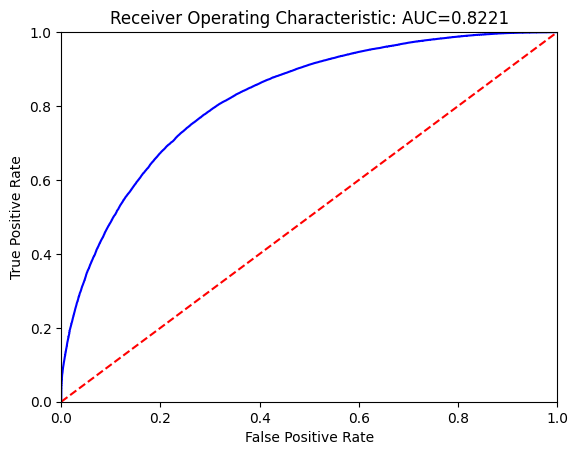

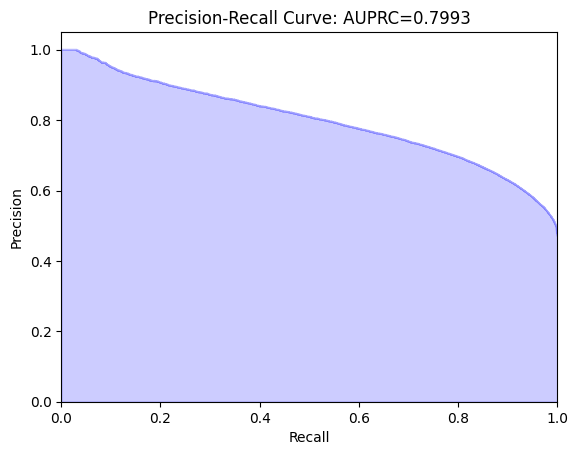

In [ ]:
print("MLP:")
mlp = load_model('hospitalization_triage_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [ ]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


score_NEWS
AUC: 0.5798769155123751
AUPRC: 0.5555466972504828
Sensitivity: 0.5643198348496123
Specificity: 0.5406899221471891
Score thresold: 1
2.5 97.5


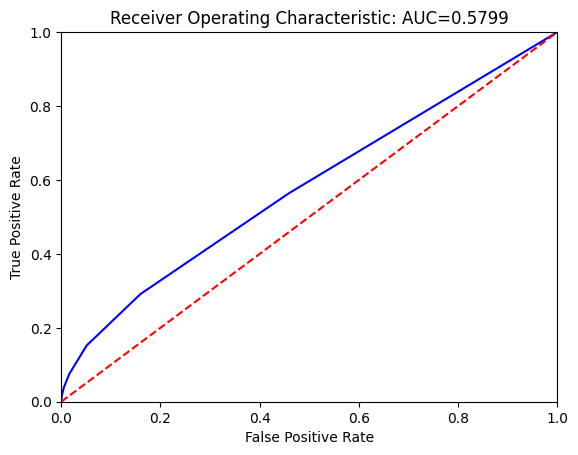

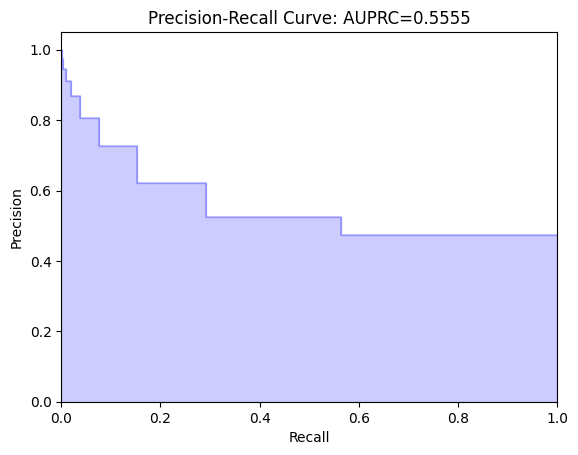

In [ ]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.5617647490314268
AUPRC: 0.5377071156285826
Sensitivity: 0.5173671955639838
Specificity: 0.5635511204783001
Score thresold: 1
2.5 97.5


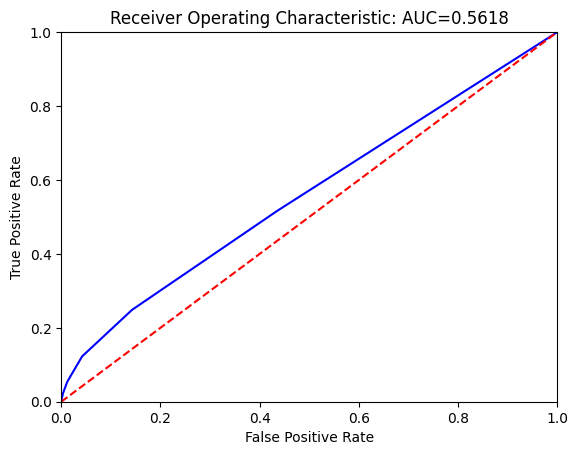

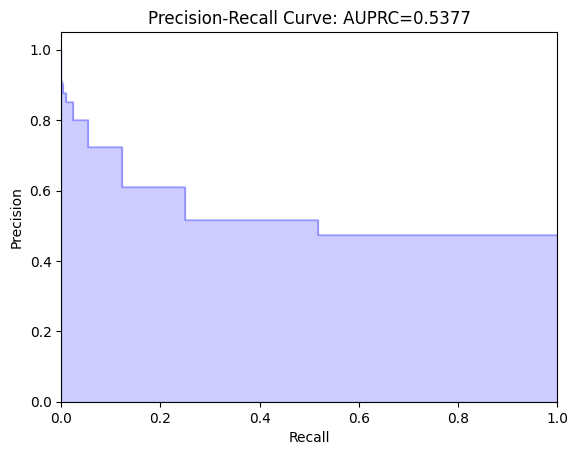

In [ ]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6712338935476605
AUPRC: 0.6068127496487556
Sensitivity: 0.7140353825103819
Specificity: 0.5583250892511507
Score thresold: 3
2.5 97.5


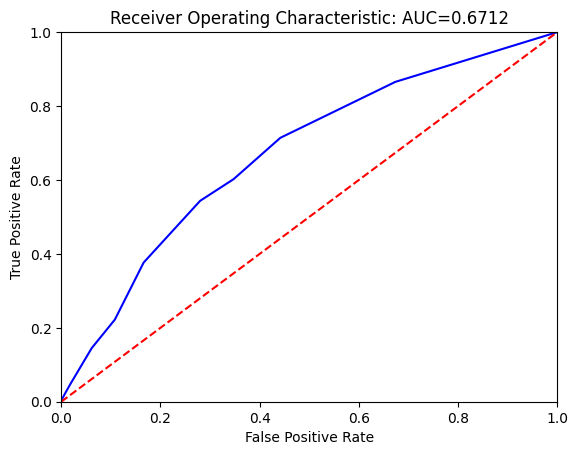

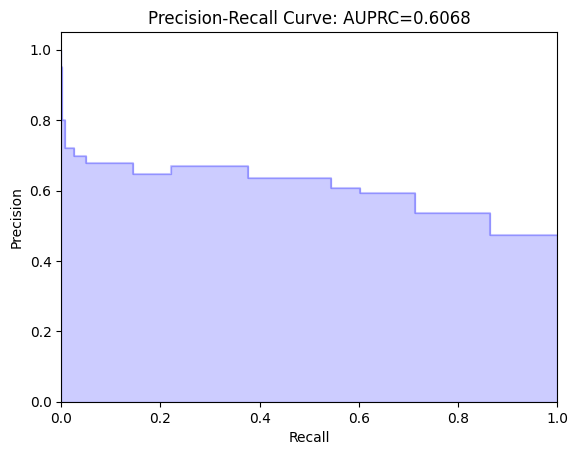

In [ ]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.5580235939721568
AUPRC: 0.5214109214590648
Sensitivity: 0.29863894956672027
Specificity: 0.8096692330852939
Score thresold: 2
2.5 97.5


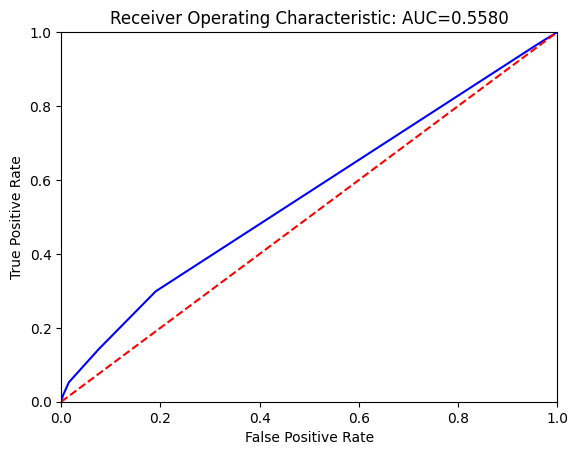

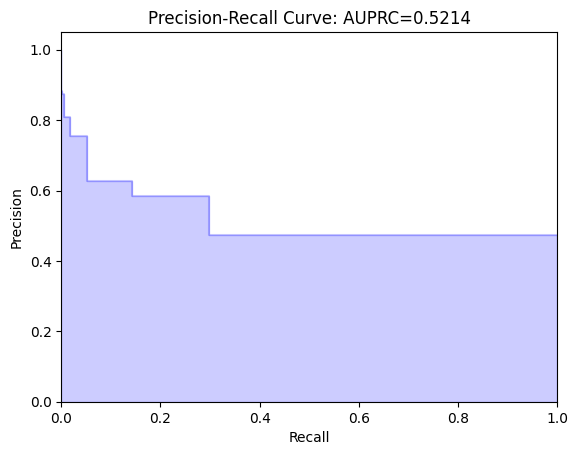

In [ ]:
get_score_performance("score_MEWS", random_seed=random_seed)

### 4. Performance output

In [ ]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task1.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.464,0.807 (0.805-0.81),0.774 (0.769-0.777),0.732 (0.73-0.751),0.734 (0.714-0.736),6.885
1,RF,0.493,0.819 (0.816-0.821),0.789 (0.785-0.792),0.747 (0.736-0.754),0.736 (0.729-0.75),87.838
2,GB,0.483,0.819 (0.816-0.821),0.796 (0.792-0.798),0.747 (0.742-0.761),0.732 (0.717-0.738),83.540
3,MLP,0.507,0.822 (0.82-0.824),0.799 (0.796-0.802),0.751 (0.746-0.766),0.738 (0.726-0.743),204.112
4,score_NEWS,1.000,0.58 (0.576-0.583),0.556 (0.551-0.558),0.564 (0.559-0.568),0.541 (0.536-0.545),0.000
5,score_NEWS2,1.000,0.562 (0.558-0.565),0.538 (0.532-0.54),0.517 (0.512-0.521),0.564 (0.559-0.568),0.000
6,score_REMS,3.000,0.671 (0.669-0.674),0.607 (0.603-0.609),0.714 (0.656-0.718),0.558 (0.555-0.609),0.000
7,score_MEWS,2.000,0.558 (0.556-0.561),0.521 (0.517-0.524),0.299 (0.295-0.303),0.81 (0.807-0.813),0.000


In [ ]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_hospitalization_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,age,0.126140
18,triage_acuity,0.110253
15,triage_sbp,0.087227
12,triage_heartrate,0.085786
16,triage_dbp,0.082980
11,triage_temperature,0.078755
17,triage_pain,0.048292
14,triage_o2sat,0.043834
13,triage_resprate,0.039762
7,n_hosp_365d,0.027097
